### Use Level Set method to extract distance function from the plasma boundary

In [1]:
from firedrake import *
from firedrake.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree

### Direct Reinitialization:

In [2]:
def interpolate_edge(p1, p2, v1, v2, c):
    t = (c - v1) / (v2 - v1)
    return (1 - t) * p1 + t * p2

In [3]:
def compute_intersections(f,c):

    V = f.function_space()
    mesh = V.mesh()

    # === Coordinate dei DOF
    coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
    dof_coords = coord_func.dat.data_ro[:]
    f_vals = f.dat.data_ro[:]

    # === Ottieni la mappa dei DOF per ogni cella
    cell_dofs = V.cell_node_map().values  # shape (num_cells, 3)

    # === Trova intersezioni f = c su edge
    intersections = []

    for dofs in cell_dofs:
        for i, j in [(0, 1), (1, 2), (2, 0)]:
            vi, vj = dofs[i], dofs[j]
            f1, f2 = f_vals[vi], f_vals[vj]
    
            if (f1 - c) * (f2 - c) <= 0:  # cambio di segno ⇒ intersezione -> ho messo <= !!
                p1, p2 = dof_coords[vi], dof_coords[vj]
                pt = interpolate_edge(p1, p2, f1, f2, c)
                #print(pt)
                intersections.append(pt)
    
    return np.array(intersections)

### Test case:

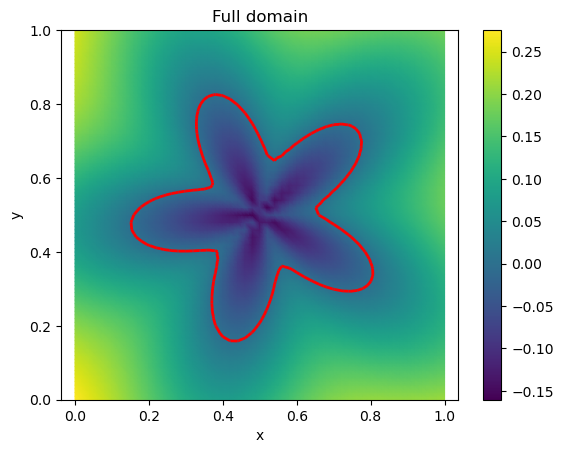

In [4]:
# === Parametri ===
c = 0  # valore della curva di livello

# === Crea la mesh e lo spazio P1 ===
mesh = UnitSquareMesh(50, 50)
V = FunctionSpace(mesh, "CG", 1)

# === Funzione f ===
x, y = SpatialCoordinate(mesh)
f = Function(V)
#f.interpolate((x-0.5)**2+(y-0.5)**2-0.25**2)
angle = atan2(x-0.5, y-0.5)
f.interpolate(0.5*(sqrt((x-0.5)**2+(y-0.5)**2) - 0.1*cos(5*angle+2.)-0.25))

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[c], colors='red', linewidths=2, axes=ax)
plt.title(r"Full domain")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

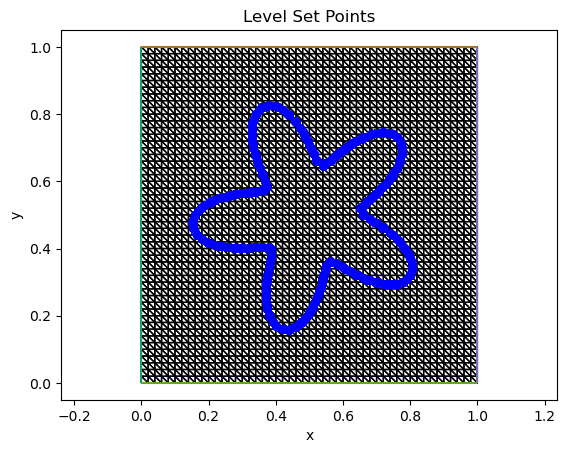

In [26]:
coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
dof_coords = coord_func.dat.data_ro[:]
f_vals = f.dat.data_ro[:]

# === calcola i punti di intersezione tra griglia e linea di livello c ====
level_points = compute_intersections(f,c)

# === Se non ci sono punti, errore
if len(level_points) == 0:
    raise RuntimeError("Nessun nodo trovato vicino alla curva di livello f = {}".format(c))

lv_pt_x = [pt[0] for pt in level_points]
lv_pt_y = [pt[1] for pt in level_points]
 
fig,ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(lv_pt_x, lv_pt_y, color='blue', linewidths = 0.5)
plt.title(r"Level Set Points")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

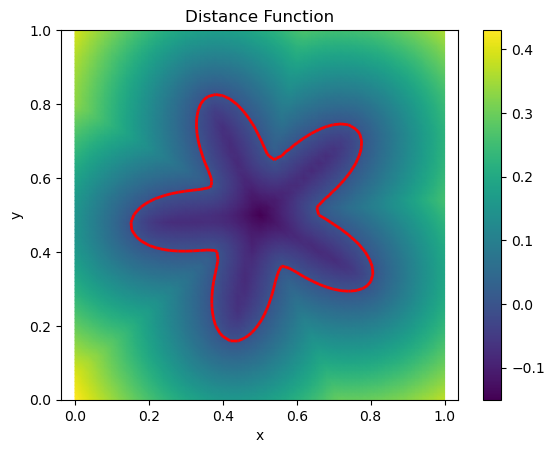

In [30]:
# === Costruisci KDTree per distanze efficienti
tree = cKDTree(level_points)

# === Calcola distanza con segno per ogni punto
signed_distance = np.zeros(len(dof_coords))
for i, (pt, f_val) in enumerate(zip(dof_coords, f_vals)):
    dist, _ = tree.query(pt)
    signed_distance[i] = np.sign(f_val - c) * dist

# === Crea funzione finale
d = Function(V)
d.dat.data[:] = signed_distance

fig,ax = plt.subplots()
fig.colorbar(tripcolor(d, axes=ax))
tricontour(d, levels=[0], colors='red', linewidths=2, axes = ax)
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

Maximum distance: 0.42993328035135053
Minimum distance: -0.15050199142678056
Maximum gradient: 1.4029276621571467
Minimum gradient: 0.11132246140845455


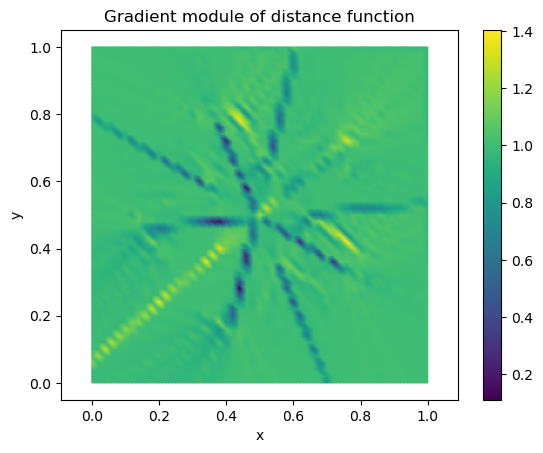

In [31]:
print(f'Maximum distance: {d.dat.data.max()}')
print(f'Minimum distance: {d.dat.data.min()}')

gradd = Function(V)
gradd.interpolate(sqrt(inner(grad(d),grad(d))))

print(f'Maximum gradient: {gradd.dat.data.max()}')
print(f'Minimum gradient: {gradd.dat.data.min()}')

fig,ax = plt.subplots()
fig.colorbar(tripcolor(gradd, axes=ax))
plt.title("Gradient module of distance function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Direct reinitialization for Tokamak

Compute the distance function from the plasma boundary, obtained after 15 fixed points iterations.

In [4]:
def G(R, psi_norm):
    r0 = 6.2
    alpha = 2.0
    beta = 0.5978
    gamma = 1.395
    lambda_ = 1.365461e6
    return lambda_ * (beta * R / r0 + (1 - beta) * r0 / R) * abs(1 - psi_norm**alpha) ** gamma

params = {
    "geometry": "ITER",
    "I": [-8.208e5, -8.621e4, 2.783e6, 1.703e6, -6.491e5, -7.971e5, -2.026e6, -2.508e6, -2.15e6, -1.874e6, -3.607e6, -2.303e6],
    "j_cv": 0,                # Vessel wall current density
    "function_space_family": "P",
    "function_space_degree": 1,
    "max_iterations": 1000,
    "tolerance": 1e-5,
    "verbose": True,
    "G": G,
    # Initial guess (can be a Constant or a Firedrake Function)
    "initial_guess": Constant(1e-4),
    "algorithm": "Picard",
}

mesh = Mesh("../meshes/ITER.msh", dim = 2, distribution_parameters={"partition": False}, reorder = True)
params["mesh"] = mesh

In [5]:
import sys
import os
sys.path.append(os.path.abspath("../"))
from solver import GradShafranovSolver

solver = GradShafranovSolver(params)

Defining function spaces of 'P1' type...


In [6]:
solver.params["max_iterations"] = 15
solver.solve()

Initializing Grad-Shafranov problem...

Iteration 1: H1 Error = 2.058849e+05, psi at boundary = 50.921951, max psi = 60.989054
Iteration 2: H1 Error = 8.164363e-01, psi at boundary = 15.146858, max psi = 21.611617
Iteration 3: H1 Error = 4.184978e-01, psi at boundary = 9.070981, max psi = 14.305145
Iteration 4: H1 Error = 1.770047e-01, psi at boundary = 6.927570, max psi = 11.602501
Iteration 5: H1 Error = 7.629403e-02, psi at boundary = 6.031002, max psi = 10.459150
Iteration 6: H1 Error = 3.914684e-02, psi at boundary = 5.568231, max psi = 9.875811
Iteration 7: H1 Error = 1.833805e-02, psi at boundary = 5.350375, max psi = 9.599379
Iteration 8: H1 Error = 8.368542e-03, psi at boundary = 5.256076, max psi = 9.479296
Iteration 9: H1 Error = 4.042270e-03, psi at boundary = 5.222138, max psi = 9.434741
Iteration 10: H1 Error = 2.896801e-03, psi at boundary = 5.218298, max psi = 9.426261
Iteration 11: H1 Error = 3.083747e-03, psi at boundary = 5.219805, max psi = 9.423902
Iteration 12: H1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


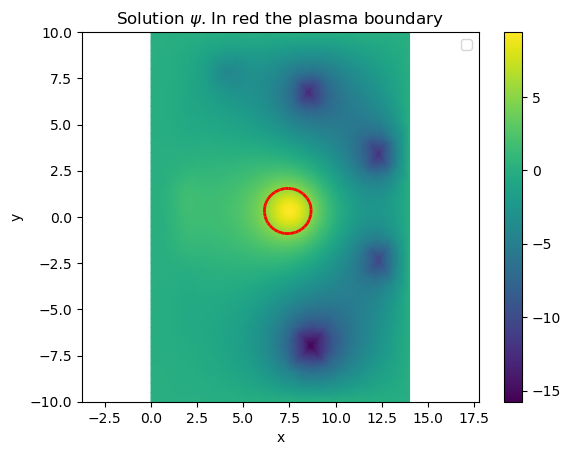

In [7]:
fig, ax = plt.subplots()
fig.colorbar(tripcolor(solver.psi, axes=ax))
tricontour(solver.psi, levels=[solver.psi0], colors='red', linewidths=2, axes=ax)
plt.title(r"Solution $\psi$. In red the plasma boundary")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

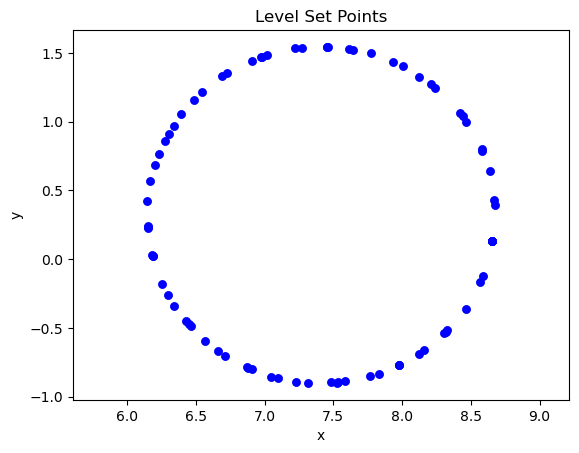

In [7]:
coord_func = Function(VectorFunctionSpace(solver.Mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(solver.Mesh)))
dof_coords = coord_func.dat.data_ro[:]
psi_vals = solver.psi.dat.data_ro[:]

# === calcola i punti di intersezione tra griglia e linea di livello c ====
level_points = compute_intersections(solver.psi,solver.psi0)

# === Se non ci sono punti, errore
if len(level_points) == 0:
    raise RuntimeError("Nessun nodo trovato vicino alla curva di livello f = {}".format(c))

lv_pt_x = [pt[0] for pt in level_points]
lv_pt_y = [pt[1] for pt in level_points]
 
fig,ax = plt.subplots()
#triplot(solver.Mesh, axes=ax)
plt.scatter(lv_pt_x, lv_pt_y, color='blue', linewidths = 0.1, axes=ax)
plt.title(r"Level Set Points")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

/opt/firedrake/firedrake/pyplot/mpl.py:223: UserWarning: The following kwargs were not used by contour: 'linewidth'
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)


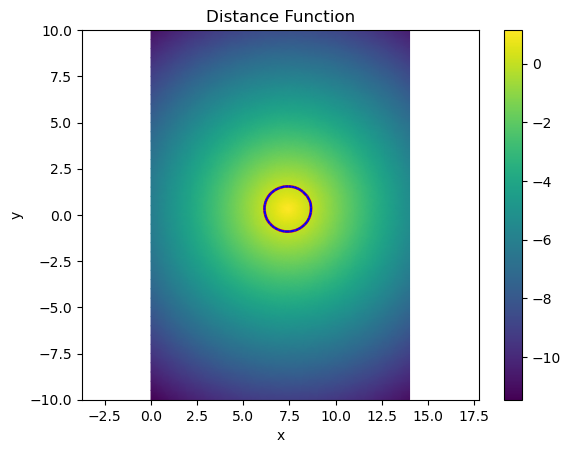

In [8]:
# === Costruisci KDTree per distanze efficienti
tree = cKDTree(level_points)

# === Calcola distanza con segno per ogni punto
signed_distance = np.zeros(len(dof_coords))
#distance = np.zeros(len(dof_coords))
for i, (pt, psi_val) in enumerate(zip(dof_coords, psi_vals)):
    dist, _ = tree.query(pt)
    signed_distance[i] = np.sign(psi_val - solver.psi0) * dist
    #distance[i] = dist

# === Crea funzione finale
d = Function(solver.V)
d.dat.data[:] = signed_distance

fig,ax = plt.subplots()
fig.colorbar(tripcolor(d, axes=ax))
tricontour(d, levels=[0], colors='red', linewidths=2, axes = ax)
tricontour(solver.psi, levels=[solver.psi0], colors = 'blue', linewidth=2, axes=ax)
plt.title("Distance Function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

Maximum distance: 1.1433563456589964
Minimum distance: -11.46073025238352
Maximum gradient: 1.2918100830704147
Minimum gradient: 0.4715882628452874


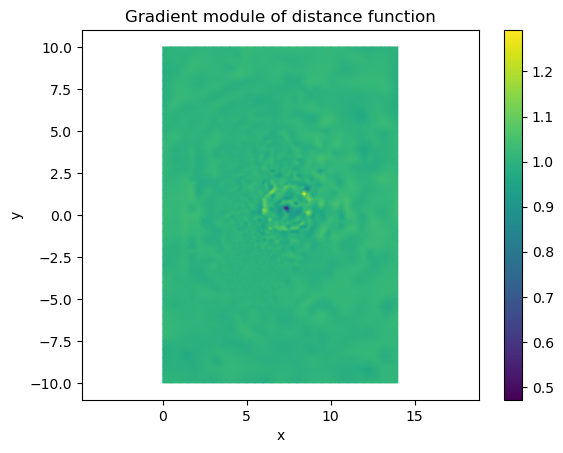

In [10]:
print(f'Maximum distance: {d.dat.data.max()}')
print(f'Minimum distance: {d.dat.data.min()}')

gradd = Function(solver.V)
gradd.interpolate(sqrt(inner(grad(d),grad(d))))

print(f'Maximum gradient: {gradd.dat.data.max()}')
print(f'Minimum gradient: {gradd.dat.data.min()}')

fig,ax = plt.subplots()
fig.colorbar(tripcolor(gradd, axes=ax))
plt.title("Gradient module of distance function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Plasma boundary mask approximation:

To define a smoothed mask using the distance function, I can rely on the results of paper https://www.sciencedirect.com/science/article/pii/S0021999109004136#fd4.
The idea is that locally I can assume the dirac delta to be 1d defined on the line orthogonal to the boundary

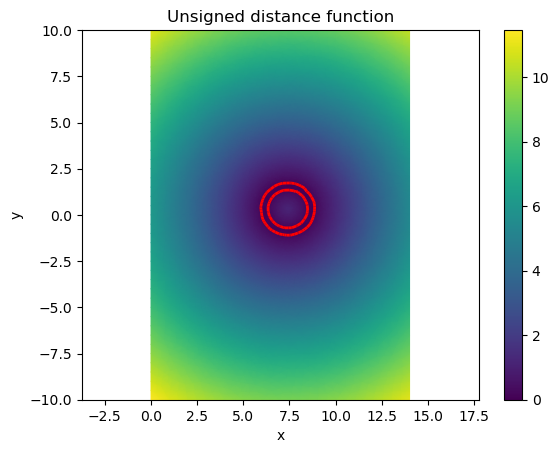

In [9]:
uns_d = Function(solver.V).interpolate(abs(d)) # unsigned distance

fig,ax = plt.subplots()
fig.colorbar(tripcolor(uns_d,axes=ax))
tricontour(uns_d, levels=[0.2], colors='red', linewidths=2, axes = ax)
plt.title("Unsigned distance function")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

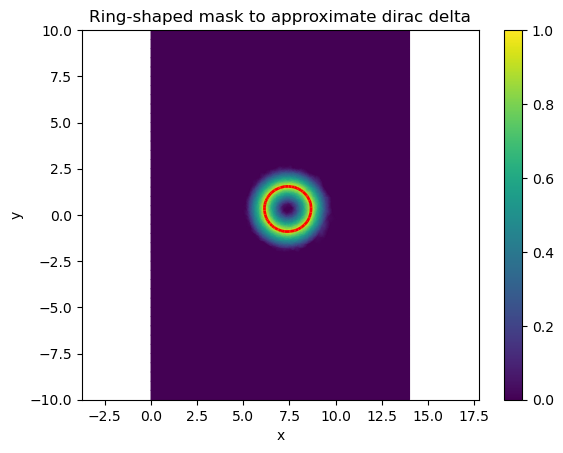

In [10]:
h = 0.3 # mesh size in the limiter region -> set as "ring width"

boundary_mask = Function(solver.V)
boundary_mask.interpolate(conditional(uns_d<=1, 1 - uns_d, Constant(0.0)))

fig,ax = plt.subplots()
fig.colorbar(tripcolor(boundary_mask,axes=ax))
tricontour(solver.psi, levels=[solver.psi0], colors='red', linewidths=2, axes = ax)
plt.title("Ring-shaped mask to approximate dirac delta")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

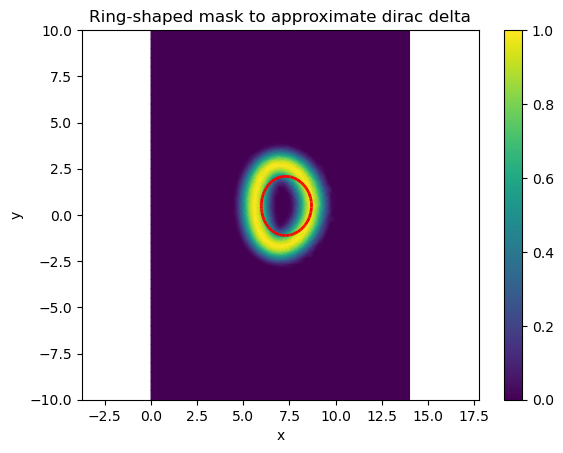

In [36]:
boundary_mask.interpolate(conditional(uns_d<=2*h, 0.5*(1 + cos(pi*uns_d/(2*h))) , Constant(0.0)))
fig,ax = plt.subplots()
fig.colorbar(tripcolor(boundary_mask,axes=ax))
tricontour(solver.psi, levels=[solver.psi0], colors='red', linewidths=2, axes = ax)
plt.title("Ring-shaped mask to approximate dirac delta")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

Una maschera così ristretta potrebbe portare instabilità numeriche. In caso prova un'altro smoothing

### Normal derivative of the flux:

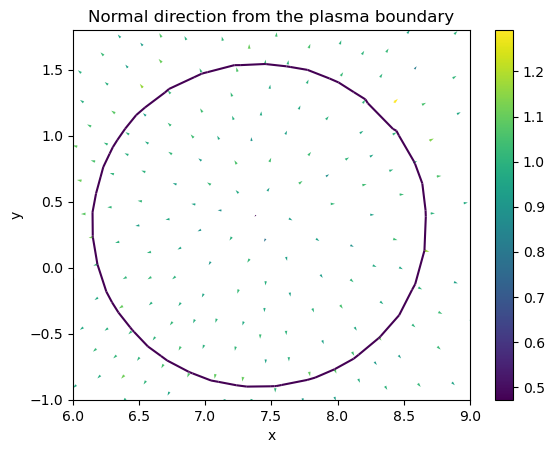

In [12]:
# Quiver plot of the distance grandient
n = Function(VectorFunctionSpace(solver.Mesh, "Lagrange", 1, dim=2)).interpolate(-grad(d))
# Il "-" per avere la normale uscente!

fig, ax = plt.subplots()
fig.colorbar(quiver(n, axes = ax, linewidth=5))
tricontour(d, levels=[0], axes=ax)
plt.title("Normal direction from the plasma boundary")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.xlim([6,9])
plt.ylim([-1,1.8])
plt.show()

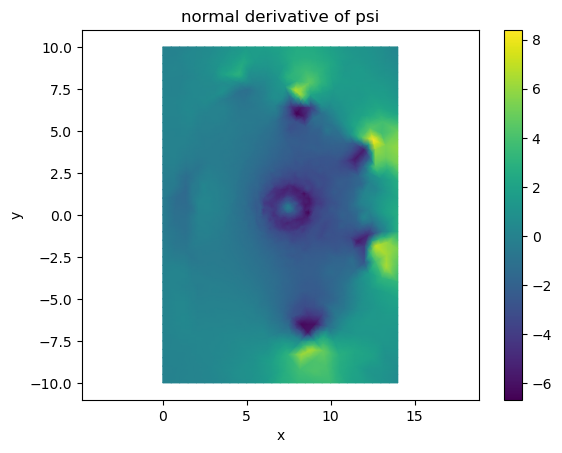

In [13]:
# Normal derivative of psi
dpsidn = Function(solver.V).interpolate(inner(grad(solver.psi),n))

fig, ax = plt.subplots()
fig.colorbar(tripcolor(dpsidn,axes=ax))
plt.title("normal derivative of psi")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

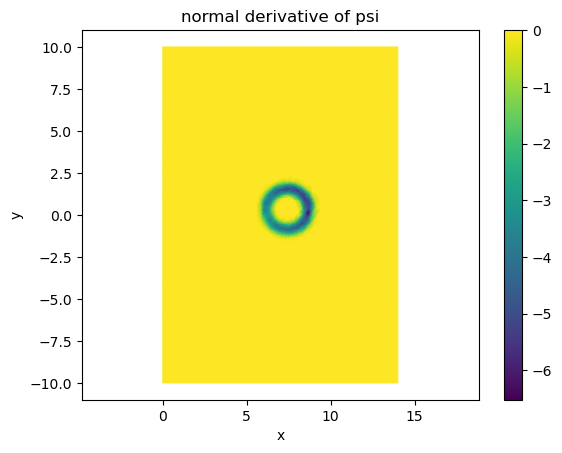

In [14]:
# product between dpsidn and mask:
dpsidn_on_boundary = Function(solver.V).interpolate(boundary_mask * dpsidn)

fig, ax = plt.subplots()
fig.colorbar(tripcolor(dpsidn_on_boundary,axes=ax))
plt.title("normal derivative of psi")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Dirac delta in a point:

Estrarre le coordinate di un punto dal suo valore:
Occhio che a volte per approssimazioni numeriche il 'f.at(x[0],x[1])==0' f0 fallisce!
Meglio confrontare gli indici direttamente -> servono due metodi specifici per psi0 e per psi_max!

In [7]:
def coordinates_from_val(f,f0):
    # Find the mesh coordinates of the point(s) in which f = f0

    V = f.function_space()
    mesh = V.mesh()

    coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
    dof_coords = coord_func.dat.data_ro[:]

    pts = []

    for x in dof_coords:
        if f.at(x[0],x[1]) == f0:
            pts.append(x)
    
    if len(pts) == 0:
        print('Nessun nodo trovato')
    
    return np.array(pts)

In [10]:
x1 = coordinates_from_val(solver.psi,solver.psi_max)[0]
print(f'Value of psi at the magnetic axes: {solver.psi.at(x1)}')
print(f'Maximum value of psi: {solver.psi_max}')

Value of psi at the magnetic axes: 9.419910320553221
Maximum value of psi: 9.419910320553221


In [11]:
psi0 = solver.psi.dat.data_ro[solver.limiter].max()
display(psi0)
x0_idx = solver.limiter[np.argmax(solver.psi.dat.data_ro[solver.limiter])]
display(x0_idx)
display(solver.psi.dat.data_ro[x0_idx])

psi_ax = solver.psi.dat.data_ro[:].max()
display(psi_ax)
x1_idx = np.argmax(solver.psi.dat.data_ro[:])
display(x1_idx)
display(solver.psi.dat.data_ro[x1_idx])

5.232317333446751

849

5.232317333446751

9.419910320553221

949

9.419910320553221

In [64]:
def Dirac_delta(V,x0):
    # define a dirac delta on space V on point x0
    mesh = V.mesh()
    coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
    dof_coords = coord_func.dat.data_ro[:]

    # Define delta_x0 function: 3 in node x0 and 0 elsewhere
    delta_x0 = Function(V).zero() # initialize with all zeros
    for i in range(0,len(dof_coords)):
        if np.allclose(dof_coords[i],x0):
            delta_x0.dat.data[i] = 3
            x0_idx = i
        
    # Compute area of the pyramid around x0:
    #area = assemble(delta_x0 * dx(domain=mesh)) # area = int_Omega(delta) = pyramid vol = Area * 3 / 3 = Area

    # Update the value of the delta in x0 s.t. the function integrates to 1 over the domain:
    #delta_x0.dat.data[x0_idx] = 3 / area
    delta_x0.dat.data[x0_idx] = 1e6
    
    return delta_x0

Integral of the Dirac delta over the whole domain: 72869.79600708884
Maximum value of the dirac delta: 1000000.0


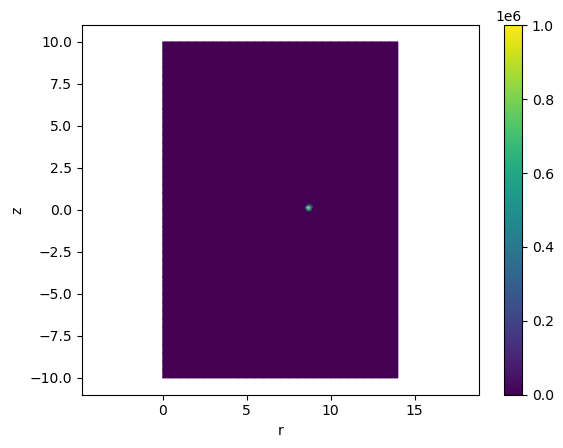

In [16]:
# Test:

# Extract coordinate x0:
coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
dof_coords = coord_func.dat.data_ro[:]

idx_x0 = solver.limiter[np.argmax(solver.psi.dat.data_ro[solver.limiter])]
x0 = dof_coords[idx_x0]

# Try to define the Dirac delta function on x0:
delta_x0 = Dirac_delta(solver.V,x0)

integral = assemble(delta_x0 * dx(domain=solver.Mesh))
print(f'Integral of the Dirac delta over the whole domain: {integral}')
print(f'Maximum value of the dirac delta: {delta_x0.dat.data.max()}')

# Plot (should look like 0 function since delta_x0 = 0 a.e.)
fig, ax = plt.subplots()
fig.colorbar(tripcolor(delta_x0, axes=ax))
plt.xlabel('r')
plt.ylabel('z')
plt.axis('equal')
plt.show()

Questa approssimazione potrebbe essere buona ma non è garantito che sia una distribuzione: integrale non è 1.
Usando questa la soluzione è brutta + grado di interpolazione è troppo alto ottengo il warning del solver.

Provo sotto a definire la delta di dirac come una gaussiana smoothata per garantire l'integrale a 1 sotto.

In [17]:
def smoothed_delta(V,x0, eps = 0.01):

    mesh = V.mesh()
    coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
    dof_coords = coord_func.dat.data_ro[:]

    # Extract distance from the point:
    tree = cKDTree([x0])
    dist, _ = tree.query(dof_coords)
    
    # Define smoothed delta function as gaussian:
    r = Function(solver.V)
    r.dat.data[:] = dist
    delta_x0 = Function(V).interpolate( exp(- (r/eps)**2 / 2) / (sqrt(2*pi)*eps) )

    return delta_x0

Integral of the Dirac delta over the whole domain: 1.2572019190558148
Maximum value of the dirac delta: 0.7978845608028654


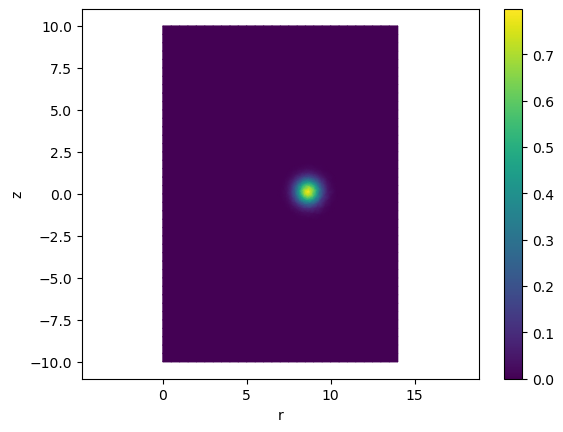

In [18]:
# Test:

# Extract coordinate x0:
coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
dof_coords = coord_func.dat.data_ro[:]

idx_x0 = solver.limiter[np.argmax(solver.psi.dat.data_ro[solver.limiter])]
x0 = dof_coords[idx_x0]

# Try to define the Dirac delta function on x0:
delta_x0 = smoothed_delta(solver.V,x0, eps = 0.5)

integral = assemble(delta_x0 * dx(domain=solver.Mesh))
print(f'Integral of the Dirac delta over the whole domain: {integral}')
print(f'Maximum value of the dirac delta: {delta_x0.dat.data.max()}')

# Plot
fig, ax = plt.subplots()
fig.colorbar(tripcolor(delta_x0, axes=ax))
plt.xlabel('r')
plt.ylabel('z')
plt.axis('equal')
plt.show()

### Newton Iteration

In [19]:
def form_a(W):

    m = W.mesh()
    x,y = SpatialCoordinate(m)

    psi, lambda0, lambda1 = TrialFunctions(W)
    phi, v0, v1 = TestFunctions(W)

    mu0 = 4e-7 * pi  # Permeability of free space (in IS units)
    
    a = ( 1 / (mu0 * x) * dot(grad(psi), grad(phi)) ) * dx(domain = m)
    return a

In [20]:
def form_b(W, G, psi_N, plasma_mask, vacuum_tag):

    m = W.mesh()
    x,y = SpatialCoordinate(m)

    phi, v0, v1 = TestFunctions(W)

    # Plasma current contribution:
    b = plasma_mask *  G(x,psi_N) * phi * dx(vacuum_tag, domain=m)
    return b

In [21]:
def form_c(W, j_coils, coils_tags):

    m = W.mesh()
    phi, v0, v1 = TestFunctions(W)

    # Vessel wall contribution:
    #c = j_cv * phi * dx(vessel_tag, domain=mesh)
    c = 0.0 * dx(domain=m)
    
    # Coil contribution::
    for i in range(len(j_coils)):
        c += j_coils[i] * phi * dx(coils_tags[i], domain=m)  # Coils are indexed from 1 to 12 in the mesh
    
    return c

In [65]:
def form_d(W,psi_old, psi_N, dpsidn, G, dGdpsiN, plasma_mask, boundary_mask, vacuum_tag):

    # Define trial and test functions:
    m = W.mesh()
    x,y = SpatialCoordinate(m)
    psi, lambda0, lambda1 = TrialFunctions(W)
    phi, v0, v1 = TestFunctions(W)

    # Ientify points x0 and x1:
    coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))
    dof_coords = coord_func.dat.data_ro[:]

    idx_x0 = solver.limiter[np.argmax(psi_old.dat.data_ro[solver.limiter])]
    idx_x1 = np.argmax(psi_old.dat.data_ro[:])

    x0 = dof_coords[idx_x0]
    x1 = dof_coords[idx_x1]

    # Evaluate psi_old at x0 and x1 
    psi0 = psi_old.at(x0)
    psi_max = psi_old.at(x1)
    
    # Gateaux derivative of psi_N w.r.t. psi:
    e = 1/(psi_max - psi0)**2 * ((psi0-psi_max)*psi + (psi_old-psi0)*lambda1 + (psi_max-psi_old)*lambda0)

    # Surface integral term:
    d = plasma_mask * dGdpsiN(x,psi_N) * e * phi * dx(vacuum_tag, domain = m)

    # Boundary term:
    d = boundary_mask * G(x,1.0) * 1/dpsidn * (lambda0 - psi) * phi * dx(vacuum_tag, domain = m)

    # Point sources in x0 and x1 for trial function evaluation:
    V = psi_old.function_space()
    delta_x0 = Dirac_delta(V,x0)
    delta_x1 = Dirac_delta(V,x1)
    #delta_x0 = smoothed_delta(V,x0,eps=1)
    #delta_x1 = smoothed_delta(V,x1,eps=1)

    # Bilinear forms for the lambda values:
    l0 = ( psi - lambda0 ) * delta_x0 * v0 * dx(domain = m)
    l1 = ( psi - lambda1 ) * delta_x1 * v1 * dx(domain = m)

    return d, l0, l1

In [23]:
# Derivative of G:
def dGdpsiN(R, psiN):
    r0 = 6.2
    alpha = 2.0
    beta = 0.5978
    gamma = 1.395
    lambda_ = 1.365461e6
    return lambda_ * (beta * R / r0 + (1 - beta) * r0 / R) * gamma * abs(1 - psiN**alpha) ** (gamma-1) * (-alpha*psiN**(alpha-1))

#### Perform some Picard iteration to start from a decent initial condition:

In [66]:
solver = GradShafranovSolver(params)
solver.params["max_iterations"] = 1
solver.solve()

Defining function spaces of 'P1' type...
Initializing Grad-Shafranov problem...

Iteration 1: H1 Error = 2.058849e+05, psi at boundary = 50.921951, max psi = 60.989054
Solver did not converge after 1 iterations. Final H1 Error = 2.058849e+05



In [67]:
# Normalize flux + extract max and limiter intersection point:
psi_N = Function(solver.V)
solver.normalize_flux(solver.psi,psi_N)

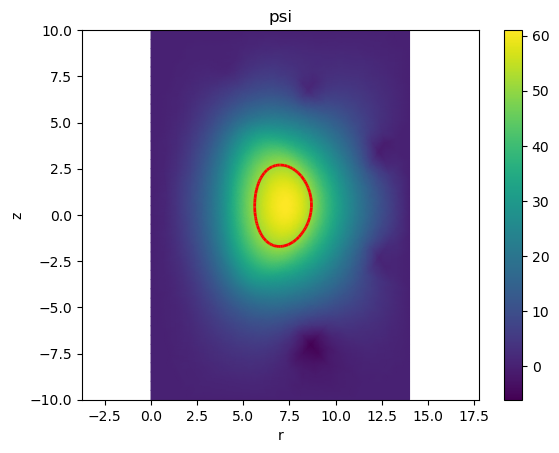

In [68]:
# Plot:
fig, ax = plt.subplots()
fig.colorbar(tripcolor(solver.psi,axes=ax))
tricontour(solver.psi, levels=[solver.psi0], colors='red', linewidths=2, axes = ax)
plt.title("psi")
plt.xlabel('r')
plt.ylabel('z')
plt.axis('equal')
plt.show()

#### Perform one Newton iteration:

CASO psi, lambda0, lambda1:

In [69]:
# Define mixed function space:
R = FunctionSpace(solver.Mesh, 'R', 0)
W = solver.V * R * R

firedrake:WARNING Real block detected, generating Schur complement elimination PC


Error L2: 0.0026409457592817764


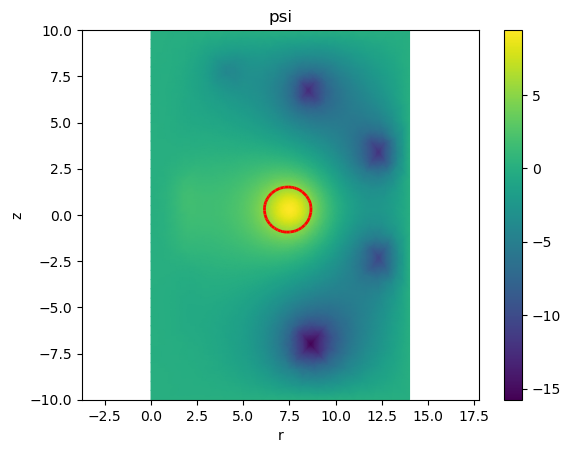

In [86]:
# Save old solution to compute error:
psi_old = Function(solver.V).interpolate(solver.psi)

# Define plasma mask:
epsilon = 0.01
solver.plasma_mask.interpolate(0.5 + 0.5 * tanh((solver.psi - solver.psi0) / (epsilon * solver.psi0)))

# Define plasma boundary mask to "simulate" linear integral:
coord_func = Function(VectorFunctionSpace(solver.Mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(solver.Mesh)))
dof_coords = coord_func.dat.data_ro[:]
psi_vals = solver.psi.dat.data_ro[:]
level_points = compute_intersections(solver.psi,solver.psi0)
tree = cKDTree(level_points)
signed_distance = np.zeros(len(dof_coords))
for i, (pt, psi_val) in enumerate(zip(dof_coords, psi_vals)):
    dist, _ = tree.query(pt)
    signed_distance[i] = np.sign(psi_val - solver.psi0) * dist

d = Function(solver.V)
d.dat.data[:] = signed_distance
uns_d = Function(solver.V).interpolate(abs(d))
boundary_mask = Function(solver.V).interpolate(conditional(uns_d<2, 0.5*(1 + cos(pi*uns_d/2)) , Constant(0.0)))

# Normal derivative for psi at plasma boundary (computed everywhere)
n = Function(VectorFunctionSpace(solver.Mesh, "Lagrange", 1, dim=2)).interpolate(grad(d)) # is the outwards normal on plasma boundary
dpsidn = Function(solver.V).interpolate(inner(grad(solver.psi),n))

# Identify points x0 and x1:
coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
dof_coords = coord_func.dat.data_ro[:]

idx_x0 = solver.limiter[np.argmax(psi_old.dat.data_ro[solver.limiter])]
idx_x1 = np.argmax(psi_old.dat.data_ro[:])

x0 = dof_coords[idx_x0]
x1 = dof_coords[idx_x1]

# Define forms:
a = form_a(W)
b = form_b(W,G,psi_N,solver.plasma_mask,solver.tags['inside limiter'])
c = form_c(W,solver.j_coils,solver.tags['coils'])

# Homogeneous Dirichlet Boundary Conditions:
bcs = [DirichletBC(W.sub(0), 0, "on_boundary")]

# Define function to store the solution:
w = Function(W)

# Perfom one Newton iteration:
d, l0, l1 = form_d(W,psi_old, psi_N, dpsidn, G, dGdpsiN, solver.plasma_mask, boundary_mask, solver.tags['inside limiter'])
lhs = a - d + l0 + l1 # bilinear form
rhs = b + c # linear form
solve(lhs == rhs , w, bcs=bcs)

ps, lam0, lam1 = split(w)
solver.psi.interpolate(ps)

# Normalize flux + extract max and limiter intersection point:
solver.normalize_flux(solver.psi,psi_N)

# Compute error:
err = errornorm(solver.psi, psi_old, 'H1') / norm(psi_old, 'H1')
print(f'Error L2: {err}')

# Plot:
fig, ax = plt.subplots()
fig.colorbar(tripcolor(solver.psi,axes=ax))
tricontour(solver.psi, levels=[solver.psi0], colors='red', linewidths=2, axes = ax)
plt.title("psi")
plt.xlabel('r')
plt.ylabel('z')
plt.axis('equal')
plt.show()

In [60]:
print(f'Value of lambda0: {w.sub(1).dat.data_ro[0]}')
print(f'Value of psi(x0): {solver.psi0}')
print(f'Value of lambda1: {w.sub(2).dat.data_ro[0]}')
print(f'Value of psi(x1): {solver.psi_max}')

Value of lambda0: 5.032016846472198
Value of psi(x0): 5.231092543120366
Value of lambda1: 9.332075184368186
Value of psi(x1): 9.401633474443877


### PDE-based Reinitialization:

In [ ]:
#V = solver.V # P1 elements
V = FunctionSpace(solver.Mesh, "DG", 1) # Discontinuous Galerkin

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


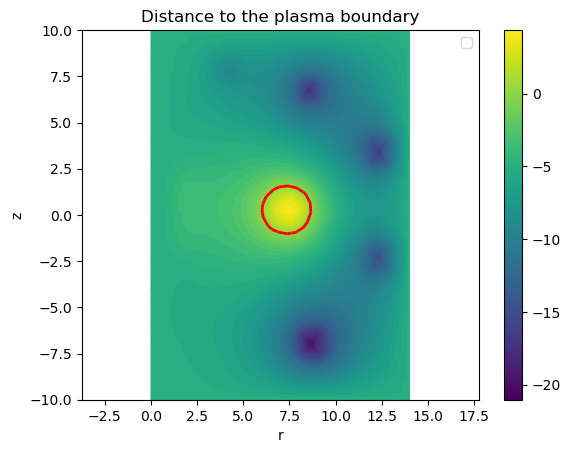

5.313408070256726

In [ ]:
dist = Function(V, name="Distance")
dist.interpolate(solver.psi - solver.psi0)

fig, ax = plt.subplots()
fig.colorbar(tripcolor(dist, axes=ax))
tricontourf(dist, levels=50, cmap='viridis', axes=ax)
tricontour(dist, levels=[0], colors='red', linewidths=2, axes=ax)
plt.title(r"Distance to the plasma boundary")
plt.xlabel("r")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()

display(solver.psi0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


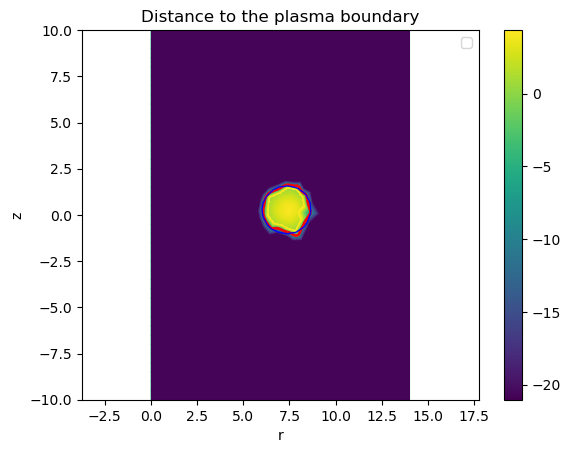

Maximum of the sign function: 1.0
Minimum of the sign function: -1.0


In [ ]:
# Define sign function as velocity:
sgn_phi = Function(V)
epsilon = 1e-3
sgn_phi.interpolate(tanh(dist / epsilon))

fig, ax = plt.subplots()
fig.colorbar(tripcolor(dist, axes=ax))
tricontourf(sgn_phi, levels=50, cmap='viridis', axes=ax)
tricontour(sgn_phi, levels=[0], colors='red', linewidths=2, axes=ax)
tricontour(dist, levels=[0], colors='blue', linewidths=1, axes=ax)
plt.title(r"Distance to the plasma boundary")
plt.xlabel("r")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()

print(f"Maximum of the sign function: {sgn_phi.dat.data.max()}")
print(f"Minimum of the sign function: {sgn_phi.dat.data.min()}")

In [ ]:
# Need to perform re-initialization to ensure the level set is a signed distance function
phi_old = Function(V) # previous iteration distance function

h = 0.4 # mesh size close to limiter

phi_trial = TrialFunction(V) # trial function for the level set equation
xsi = TestFunction(V) # test function for the level set equation
phi = Function(V)
#BCs = DirichletBC(V, -solver.psi0, solver.tags['boundary'])


#### Forward Euler:
Error increases with the iterations using forward euler scheme:

tau = 0.00, error = 9.20e-04
tau = 0.01, error = 9.18e-04
tau = 0.01, error = 9.17e-04
tau = 0.02, error = 9.16e-04
tau = 0.02, error = 9.14e-04
tau = 0.02, error = 9.13e-04
tau = 0.03, error = 9.12e-04
tau = 0.03, error = 9.11e-04
tau = 0.04, error = 9.09e-04
tau = 0.04, error = 9.08e-04
tau = 0.04, error = 9.07e-04
tau = 0.05, error = 9.05e-04
tau = 0.05, error = 9.04e-04
tau = 0.06, error = 9.03e-04
tau = 0.06, error = 9.02e-04
tau = 0.06, error = 9.00e-04
tau = 0.07, error = 8.99e-04
tau = 0.07, error = 8.98e-04
tau = 0.08, error = 8.96e-04
tau = 0.08, error = 8.95e-04
tau = 0.08, error = 8.94e-04
tau = 0.09, error = 8.93e-04
tau = 0.09, error = 8.91e-04
tau = 0.10, error = 8.90e-04
tau = 0.10, error = 8.89e-04
tau = 0.10, error = 8.87e-04
tau = 0.11, error = 8.86e-04
tau = 0.11, error = 8.85e-04
tau = 0.12, error = 8.84e-04
tau = 0.12, error = 8.82e-04
tau = 0.12, error = 8.81e-04
tau = 0.13, error = 8.80e-04
tau = 0.13, error = 8.78e-04
tau = 0.14, error = 8.77e-04
tau = 0.14, er

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


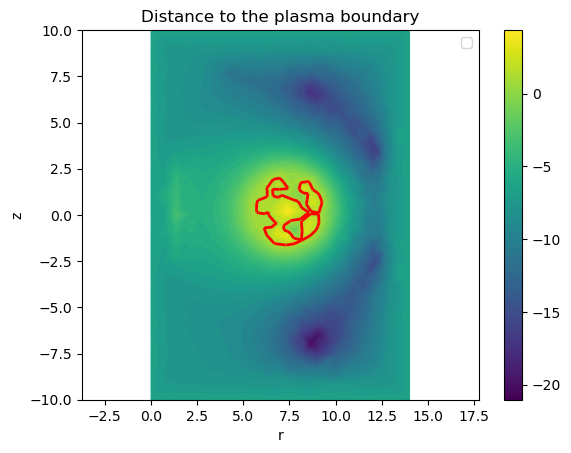

In [ ]:
tau = 0.0    # psuedo-time
dtau = 0.01 * h

tol = 1e-5 # tolerance for convergence
err = 1    # initial error# Perform iterations of Hamilton-Jacobi equation:

# Define the linear solver of the weak form of Hamiltnon-Jacobi equation
a = 1 / dtau * phi_trial * xsi * dx
A = assemble(a)
LinSolv = LinearSolver(A, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})

phi.assign(dist)  # Initialize phi with the distance function

while err > tol and tau < 80:
    phi_old.assign(phi)

    L = 1/dtau * phi_old * xsi * dx + sgn_phi * (1 - sqrt(dot(grad(phi_old), grad(phi_old))) ) * xsi * dx
    b = assemble(L)
    LinSolv.solve(phi, b)

    err_old = err
    err = norm(phi - phi_old, 'L2') / norm(phi_old, 'L2')
    tau = tau + dtau
    print(f"tau = {tau:.2f}, error = {err:.2e}")

    if err_old < err:
        print("Error increased.")
        break

fig, ax = plt.subplots()
fig.colorbar(tripcolor(dist, axes=ax))
tricontourf(phi, levels=50, cmap='viridis', axes=ax)
tricontour(phi, levels=[0], colors='red', linewidths=2, axes=ax)
plt.title(r"Distance to the plasma boundary")
plt.xlabel("r")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()


#### Implicit Euler:

In [13]:
tau = 0.0    # psuedo-time
dtau = 0.9 * h

tol = 1e-5 # tolerance for convergence
err = 1    # initial error# Perform iterations of Hamilton-Jacobi equation:

phi.assign(dist)
a = 1 / dtau * phi * xsi * dx - sgn_phi * (1 - sqrt(dot(grad(phi), grad(phi))) ) * xsi * dx

while err > tol and tau < 80:

    L = - 1/dtau * phi_old * xsi * dx
    F = a + L
    solve(F == 0, phi, bcs=[BCs],
          solver_parameters={'snes_type': 'newtonls',
                         'ksp_type': 'preonly',
                         'pc_type': 'lu'})   # Firedrake nonlinear solver
 
    err = norm(phi - phi_old, 'L2') / norm(phi_old, 'L2')
    tau = tau + dtau
    print(f"tau = {tau:.2f}, error = {err:.2e}")

fig, ax = plt.subplots()
fig.colorbar(tripcolor(dist, axes=ax))
tricontourf(phi, levels=50, cmap='viridis', axes=ax)
tricontour(phi, levels=[0], colors='red', linewidths=2, axes=ax)
plt.title(r"Distance to the plasma boundary")
plt.xlabel("r")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()

ConvergenceError: Nonlinear solve failed to converge after 50 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT

#### Artificial Viscosity:

tau = 0.00, error = 2.75e-02
tau = 0.01, error = 2.14e-02
tau = 0.01, error = 1.82e-02
tau = 0.02, error = 1.61e-02
tau = 0.02, error = 1.46e-02
tau = 0.02, error = 1.34e-02
tau = 0.03, error = 1.25e-02
tau = 0.03, error = 1.17e-02
tau = 0.04, error = 1.10e-02
tau = 0.04, error = 1.05e-02
tau = 0.04, error = 9.98e-03
tau = 0.05, error = 9.56e-03
tau = 0.05, error = 9.18e-03
tau = 0.06, error = 8.84e-03
tau = 0.06, error = 8.54e-03
tau = 0.06, error = 8.26e-03
tau = 0.07, error = 8.00e-03
tau = 0.07, error = 7.76e-03
tau = 0.08, error = 7.54e-03
tau = 0.08, error = 7.33e-03
tau = 0.08, error = 7.13e-03
tau = 0.09, error = 6.95e-03
tau = 0.09, error = 6.77e-03
tau = 0.10, error = 6.60e-03
tau = 0.10, error = 6.44e-03
tau = 0.10, error = 6.29e-03
tau = 0.11, error = 6.15e-03
tau = 0.11, error = 6.01e-03
tau = 0.12, error = 5.87e-03
tau = 0.12, error = 5.74e-03
tau = 0.12, error = 5.62e-03
tau = 0.13, error = 5.50e-03
tau = 0.13, error = 5.38e-03
tau = 0.14, error = 5.27e-03
tau = 0.14, er

/opt/firedrake/firedrake/pyplot/mpl.py:223: UserWarning: No contour levels were found within the data range.
  return method(triangulation, toreal(values, complex_component), *args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


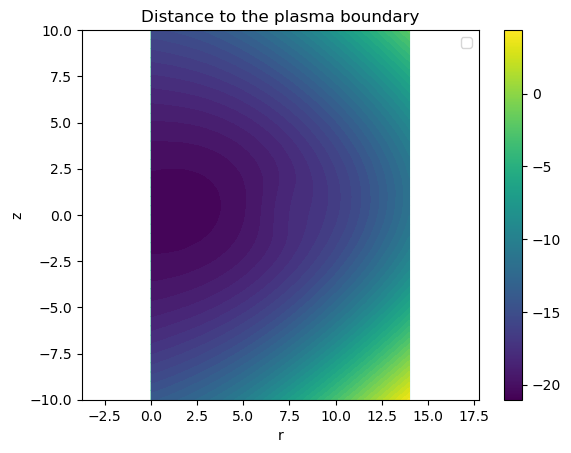

In [ ]:
tau = 0.0    # psuedo-time
dtau = 0.01 * h

tol = 1e-5 # tolerance for convergence
err = 1    # initial error# Perform iterations of Hamilton-Jacobi equation:

mu = h**2 / (2 * dtau)   # Lax-Friedrichs
#mu = dtau / 2           # Lax-Wendroff
#mu = 0.1 * h            # Small viscosity
gamma = 1.0

# Define the linear solver of the weak form of Hamiltnon-Jacobi equation
a = 1 / dtau * phi_trial * xsi * dx + mu * inner(grad(phi_trial), grad(xsi)) * dx
# Boundary conditions on the rectangular domain:
a -= gamma * mu * inner(grad(phi_trial), Constant((0.0,-1.0))) * xsi * ds(26, domain = solver.Mesh)
a -= gamma * mu * inner(grad(phi_trial), Constant((1.0,0.0))) * xsi * ds(27, domain = solver.Mesh)
a -= gamma * mu * inner(grad(phi_trial), Constant((0.0,1.0))) * xsi * ds(28, domain = solver.Mesh)
a -= gamma * mu * inner(grad(phi_trial), Constant((-1.0,0.0))) * xsi * ds(29, domain = solver.Mesh)
A = assemble(a)
LinSolv = LinearSolver(A, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})

phi.assign(dist)  # Initialize phi with the distance function

while err > tol and tau < 80:
    phi_old.assign(phi)

    L = 1/dtau * phi_old * xsi * dx + sgn_phi * (1 - sqrt(dot(grad(phi_old), grad(phi_old))) ) * xsi * dx
    b = assemble(L)
    LinSolv.solve(phi, b)

    err_old = err
    err = norm(phi - phi_old, 'L2') / norm(phi_old, 'L2')
    tau = tau + dtau
    print(f"tau = {tau:.2f}, error = {err:.2e}")

    if err_old < err:
        print("Error increased.")
        break

fig, ax = plt.subplots()
fig.colorbar(tripcolor(dist, axes=ax))
tricontourf(phi, levels=50, cmap='viridis', axes=ax)
tricontour(phi, levels=[0], colors='red', linewidths=2, axes=ax)
plt.title(r"Distance to the plasma boundary")
plt.xlabel("r")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


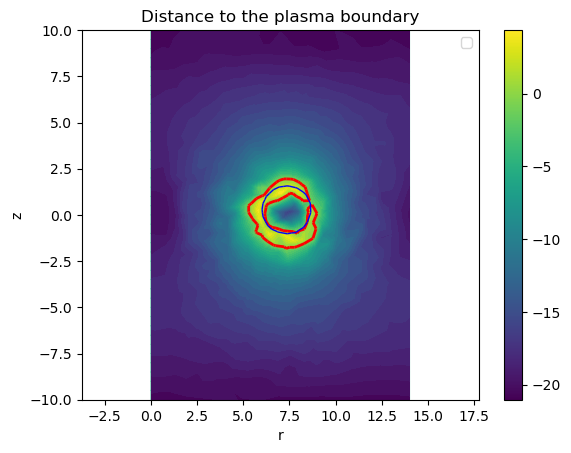

Maximum of the gradient: 0.05679440196026669
Minimum of the gradient: 0.0006407257045355101


In [51]:
# Try to plot the gradient:

dphi = Function(solver.V, name="Gradient of phi")
dphi.interpolate(sqrt(inner(grad(phi),grad(phi))))

fig, ax = plt.subplots()
fig.colorbar(tripcolor(dist, axes=ax))
tricontourf(dphi, levels=50, cmap='viridis', axes=ax)
tricontour(dphi, levels=[0.045], colors='red', linewidths=2, axes=ax)
tricontour(dist, levels=[0], colors='blue', linewidths=1, axes=ax)
plt.title(r"Distance to the plasma boundary")
plt.xlabel("r")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()

print(f"Maximum of the gradient: {dphi.dat.data.max()}")
print(f"Minimum of the gradient: {dphi.dat.data.min()}")